In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import r2_score

In [2]:
data=pd.read_csv("/content/Google_Stock_Price_Train.csv")
data

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400"
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100"
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"


In [3]:
data['Close']=data['Close'].str.replace(',','').astype(float)
data['Volume']=data['Volume'].str.replace(',','').astype(float)

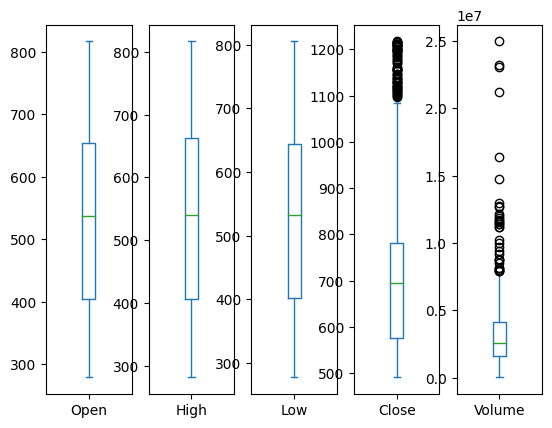

In [5]:
data[['Open','High','Low','Close','Volume']].plot(kind= 'box' ,layout=(1,5),subplots=True)
plt.show()

In [6]:
scaler = MinMaxScaler()
data_without_date = data[['Open','High','Low','Close','Volume']]
data_scaled = pd.DataFrame(scaler.fit_transform(data_without_date))

In [7]:
data_scaled

,0,1,2,3,4
0,0.085814,0.096401,0.090449,0.237573,0.295258
1,0.097012,0.098344,0.098235,0.241514,0.229936
2,0.094334,0.092517,0.094086,0.228781,0.263612
3,0.091562,0.088819,0.088006,0.216419,0.216179
4,0.079842,0.076718,0.061070,0.178548,0.467797
...,...,...,...,...,...
1253,0.952043,0.955292,0.966169,0.411656,0.024650
1254,0.951633,0.964853,0.966889,0.413916,0.031286
1255,0.957251,0.958074,0.958441,0.404958,0.045891
1256,0.937960,0.942574,0.950333,0.401844,0.029491


<ipython-input-8-373595b0d5cd>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr())


<Axes: >

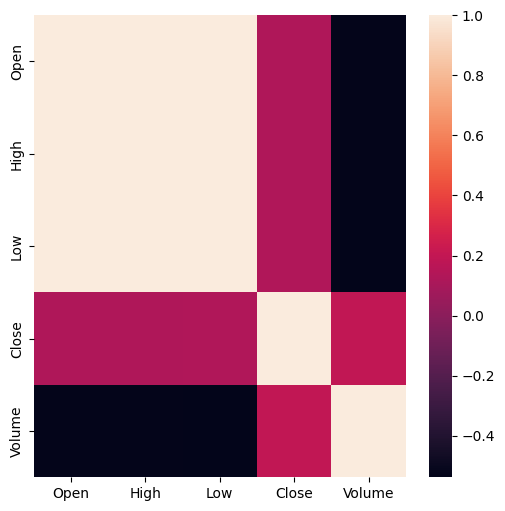

In [8]:
plt.figure(figsize=(6,6))
sns.heatmap(data.corr())

In [9]:
data_scaled=data_scaled.drop([1,2,4], axis=1)
data_scaled

,0,3
0,0.085814,0.237573
1,0.097012,0.241514
2,0.094334,0.228781
3,0.091562,0.216419
4,0.079842,0.178548
...,...,...
1253,0.952043,0.411656
1254,0.951633,0.413916
1255,0.957251,0.404958
1256,0.937960,0.401844


In [13]:
def split_seq_multivariate(sequence, n_past, n_future):

  x, y = [], []
  for window_start in range(len(sequence)):
      past_end = window_start + n_past
      future_end = past_end + n_future
      if future_end > len(sequence):
        break
      # slicing the past and future parts of the window
      past = sequence[window_start:past_end, :]
      future = sequence[past_end:future_end, -1]
      x.append(past)
      y.append(future)
  return np.array(x), np.array(y)

In [14]:
# specify the window size
n_steps = 60
data_scaled = data_scaled.to_numpy()
data_scaled.shape

(1258, 2)

In [15]:
X, y = split_seq_multivariate(data_scaled, n_steps,1)

In [16]:
# X is in the shape of [samples, timesteps, features]
print(X.shape)
print(y.shape)
# make y to the shape of [samples]
y=y[:,0]
y.shape

(1198, 60, 2)
(1198, 1)


(1198,)

In [17]:
# split into train/test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=50)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(958, 60, 2) (240, 60, 2) (958,) (240,)


In [19]:
# further dividing the training set into train and validation data
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=30)

In [20]:
# define RNN model
model = Sequential()
model.add(LSTM(612, input_shape=(n_steps,2)))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(1))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 612)               1505520   
                                                                 
 dense (Dense)               (None, 50)                30650     
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 30)                1530      
                                                                 
 dense_3 (Dense)             (None, 1)                 31        
                                                                 
Total params: 1,540,281
Trainable params: 1,540,281
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [25]:
# fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2, validation_data=(X_val, y_val))

Epoch 1/100
24/24 - 11s - loss: 4.4165e-04 - mae: 0.0146 - val_loss: 0.0038 - val_mae: 0.0201 - 11s/epoch - 454ms/step
Epoch 2/100
24/24 - 11s - loss: 4.1281e-04 - mae: 0.0146 - val_loss: 0.0039 - val_mae: 0.0197 - 11s/epoch - 460ms/step
Epoch 3/100
24/24 - 11s - loss: 3.7406e-04 - mae: 0.0142 - val_loss: 0.0038 - val_mae: 0.0193 - 11s/epoch - 453ms/step
Epoch 4/100
24/24 - 12s - loss: 3.0531e-04 - mae: 0.0126 - val_loss: 0.0039 - val_mae: 0.0191 - 12s/epoch - 483ms/step
Epoch 5/100
24/24 - 11s - loss: 2.8913e-04 - mae: 0.0126 - val_loss: 0.0039 - val_mae: 0.0200 - 11s/epoch - 456ms/step
Epoch 6/100
24/24 - 11s - loss: 2.7306e-04 - mae: 0.0123 - val_loss: 0.0039 - val_mae: 0.0199 - 11s/epoch - 461ms/step
Epoch 7/100
24/24 - 11s - loss: 2.6608e-04 - mae: 0.0122 - val_loss: 0.0039 - val_mae: 0.0205 - 11s/epoch - 458ms/step
Epoch 8/100
24/24 - 11s - loss: 3.8697e-04 - mae: 0.0152 - val_loss: 0.0039 - val_mae: 0.0189 - 11s/epoch - 458ms/step
Epoch 9/100
24/24 - 12s - loss: 3.1223e-04 - mae

In [26]:
# evaluate the model
mse, mae = model.evaluate(X_test, y_test, verbose=0)
print('MSE: %.3f, RMSE: %.3f, MAE: %.3f' % (mse, np.sqrt(mse), mae)) 

MSE: 0.000, RMSE: 0.014, MAE: 0.011


In [27]:

# predicting y_test values
print(X_test.shape)
predicted_values = model.predict(X_test)
print(predicted_values.shape)
# print(predicted_values)
     

(240, 60, 2)
8/8 [==============================] - 1s 103ms/step
(240, 1)


<Figure size 1000x600 with 0 Axes>

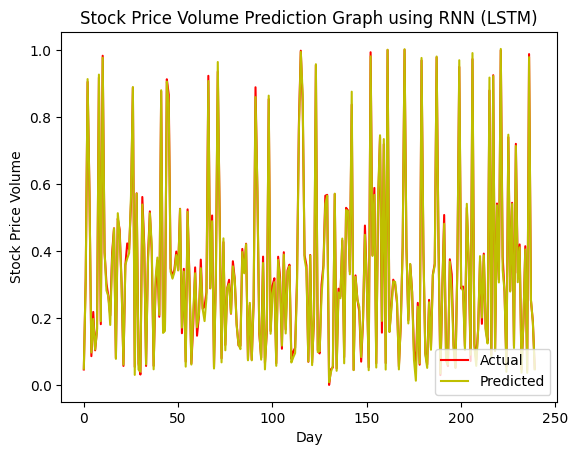

<Figure size 1000x600 with 0 Axes>

In [28]:
plt.plot(y_test,c = 'r')
plt.plot(predicted_values,c = 'y')
plt.xlabel('Day')
plt.ylabel('Stock Price Volume')
plt.title('Stock Price Volume Prediction Graph using RNN (LSTM)')
plt.legend(['Actual','Predicted'],loc = 'lower right')
plt.figure(figsize=(10,6))

In [29]:
# evaluating using R squared
R_square = r2_score(y_test, predicted_values) 
 
print(R_square)

0.9970982390022133
